这章很多包更新了，建议看ml3的代码

https://github.com/ageron/handson-ml3/blob/main/18_reinforcement_learning.ipynb

In [1]:
import gym
import matplotlib.pyplot as plt
import numpy as np

# 简单环境

In [170]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
# 渲染模式除非有策略连续指导，否则最好用rgb_array像素张量，再用plt.imshow()作图
obs = env.reset()

In [3]:
obs  # 水平位置（0是中心），速度（右正），垂直角度，角速度

(array([ 0.04245929,  0.02993055, -0.0476618 , -0.0058758 ], dtype=float32),
 {})

In [4]:
img = env.render()  # 返回图像像素的数组

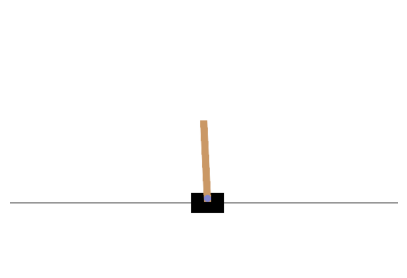

In [5]:
def plot_environment(env, figsize=(5, 4)):  # 显示图像
    plt.figure(figsize=figsize)
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    return img


plot_environment(env)
plt.show()

In [6]:
img.shape


(400, 600, 3)

In [7]:
env.action_space  # 可采取的行动

Discrete(2)

0是向左加速，1 是向右加速

In [8]:
action = 1  # 向右加速

In [9]:
obs, reward, done, truncated, info = env.step(action)  # 新状态，奖励，是否回合结束，是否截断（不懂），其他信息

In [10]:
obs


array([ 0.0430579 ,  0.2257025 , -0.04777931, -0.3132075 ], dtype=float32)

In [11]:
env.close()


# 硬代码方案

杆子向左倾斜时左移，向右倾斜时右移

In [153]:
env = gym.make("CartPole-v1", render_mode="human")
obs = env.reset()[0]
env.render()


def basic_policy(obs):  # 硬代码方法
    angle = obs[2]  # 获得杆子角度，向右是正
    return 0 if angle < 0 else 1  # 向左倾斜时左移，向右倾斜时右移


totals = []
for episode in range(30):  # 训练30回合
    episode_rewards = 0
    obs = env.reset()[0]
    for step in range(200):  # 每回合200步
        action = basic_policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        episode_rewards += reward
        if done:
            break
    totals.append((episode_rewards))
env.close()

In [13]:
env.close()


In [14]:
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)


(14.5, 8.65544144839919, 0, 29)

# 梯度策略（Policy Gradient，PG算法）

In [15]:
import tensorflow as tf
from tensorflow import keras

In [16]:
n_inputs = 4  # 四个输入状态, step()是5个游戏状态, obs是4个环境状态

keras模型

In [17]:
model = keras.Sequential(
    [
        keras.layers.Dense(5, activation="elu", input_shape=[n_inputs]),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)

单步执行函数

In [196]:
def play_one_step(env, obs, model, loss_fn):  # 执行一个动作，返回4个状态和梯度
    """根据目前状态选择动作"""
    with tf.GradientTape() as tape:  # 自动微分
        left_proba = model(obs[np.newaxis])  # 初始模型预测向左的概率，x输入模型时加一个维度
        action = tf.random.uniform([1, 1]) > left_proba  # 动作为布尔值True or Flase
        y_target = tf.constant([[1.0]]) - tf.cast(action, tf.float32)  # cast()转换数据格式
        # action为True->1，应该向左走，因此实际上要通过1-action转换为0，但只是为了算损失，下一步直接用action转换
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))  # 损失（张量）均值，*假设每次动作都是对的*
    grads = tape.gradient(loss, model.trainable_variables)  # 计算梯度
    obs, reward, done, truncated, info = env.step(int(action[0, 0].numpy()))  # 采取动作
    return obs, reward, done, truncated, grads

In [197]:
left_proba = model(obs[np.newaxis])

In [198]:
action = tf.random.uniform([1, 1]) > left_proba

多轮执行函数

In [63]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):  # 轮数
        current_rewards = []
        current_grads = []
        obs, info = env.reset()  # 初始化
        for step in range(n_max_steps):  # 执行若干回合
            obs, reward, done, truncated, grads = play_one_step(
                env, obs, model, loss_fn
            )
            current_rewards.append(reward)
            current_grads.append(grads)
            if done or truncated:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads


# 返回每一轮每一回合每一步的奖励数，和每一步的梯度张量

对奖励进行打折，越往后折扣越大，并且进行标准化

In [64]:
def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards, dtype=float)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_factor
        # 从倒数第二项开始逐个乘以折扣，一直到第一个
    return discounted


def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [
        discount_rewards(rewards, discount_factor) for rewards in all_rewards
    ]  # 对奖励应用折扣
    flat_rewards = np.concatenate(all_discounted_rewards)  # 纵向拼接
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [
        (discount_rewards - reward_mean) / reward_std
        for discount_rewards in all_discounted_rewards
    ]  # 返回标准化的折扣奖励

设定参数

In [65]:
n_iterations = 50  # 迭代次数
n_episodes_per_update = 10  # 每次迭代10回合
n_max_steps = 200  # 每回合最多训练200步
discount_factor = 0.95  # 折扣因子

指定优化器和损失函数

In [66]:
optimizer = keras.optimizers.Adam(0.01)
loss_fn = keras.losses.binary_crossentropy  # 二元交叉熵

训练方案

In [68]:
for iteration in range(n_iterations):
    # 执行一次迭代，即玩10回合，每回合最多200步，返回所有奖励和梯度
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn
    )
    
    # 打印每一次迭代数据
    total_rewards = sum(map(sum, all_rewards))
    print(
        f"\rIteration: {iteration + 1}/{n_iterations},"
        f" mean rewards: {total_rewards / n_episodes_per_update:.1f}",
        end="",
    )
    
    # 奖励打折
    all_final_rewards = discount_and_normalize_rewards(
        all_rewards, discount_factor)
    
    # 更新梯度的计算
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):  # 循环可训练的四个张量索引值
        mean_grads = tf.reduce_mean(
            [
                final_reward * all_grads[episode_index][step][var_index]
                for episode_index, final_rewards in enumerate(all_final_rewards)
                for step, final_reward in enumerate(final_rewards)
            ],
            axis=0,
        )
        # 折扣奖励（权重）乘以对应的梯度张量，episode_index和step索引出张量列表，var_index为列表四个张量索引
        # all_final_rewards 中有10个[列表]，存有每一轮的折扣后奖励，每个列表在后面的for循环提取👇
        # final_reward 是上一轮从 all_final_rewards 中提取出来的[列表]👆
        # all_grads 长度为10，代表10次训练，装有每次训练中可训练参数的梯度，每次训练的梯度有四个张量：
        # 1. (4(输入维度), 5(输入权重))； 2.(5(偏置项), )； 3.(5(输出权重), 1)； 4.(1(输出偏置), )
        # 总之，两次内循环都是为了提取final_reward并且获得索引，外循环对应训练张量all_grads

        all_mean_grads.append(mean_grads)  # 该批次四个梯度张量更新的均值的列表

    optimizer.apply_gradients(
        zip(all_mean_grads, model.trainable_variables))  # 应用梯度更新


Iteration: 150/150, mean rewards: 190.6

In [200]:
model.predict(obs[np.newaxis])

1/1 [==============================] - 0s 18ms/step


array([[0.56777954]], dtype=float32)

保存模型

In [220]:
model.save('E:/机器学习实战/机器学习实战笔记/model/RL_PG_1.h5')

读取模型

In [222]:
model = keras.models.load_model('E:/机器学习实战/机器学习实战笔记/model/RL_PG_1.h5')

# 应用算法并测试

In [224]:
def show_policy(policy, epochs=10):
    env = gym.make("CartPole-v1", render_mode="human")
    totals = []
    for i in range(epochs): # 测试轮数
        episode_rewards = 0
        obs = env.reset()[0] # 第二个输出为info，可以不要
        for _ in range(300):  # 每回合最多300步
            left_proba = policy(obs[np.newaxis])  # 初始模型预测向左的概率，x输入模型时加一个维度
            action = tf.random.uniform([1, 1]) > left_proba  # 动作为布尔值True or Flase
            obs, reward, done, truncated, info = env.step(int(action[0, 0].numpy()))
            episode_rewards += reward
            if done or truncated:
                break
        totals.append((episode_rewards))
    env.close()
    return totals

In [225]:
reward = show_policy(model)

In [217]:
reward

[127.0, 300.0, 300.0, 209.0, 300.0, 234.0, 300.0, 210.0, 158.0, 292.0]

PG算法注意点
1. 在每一步中，假设每一步动作都是对的，用神经网络估计出采取该动作的概率，并且计算最终采取的动作和概率之间的损失；进行若干次迭代，每次迭代采取几个回合，统计每一轮的最终得分和梯度（注意，梯度本身就自带若干张量，因此最终得分有两个维度，即每轮和每次迭代，而梯度也有这两个维度，但还多了一个维度包含神经网络的若干梯度张量，`用这句话理解最后训练中的梯度更新`）。

2. 要对得分进行标准化，因此表现不佳的情况会变为负数，用它乘以梯度更新，就把原本的损失转化为正向或反向的梯度更新。

3. 一次迭代之后会获得多个维度（轮次）的数据，此时再进行梯度更新

4. 计算梯度可以使用`tf`的自动微分，优化器和损失函数也可以用`tf`的函数指定。

# 马尔可夫决策过程（MDP）

一种马尔科夫链
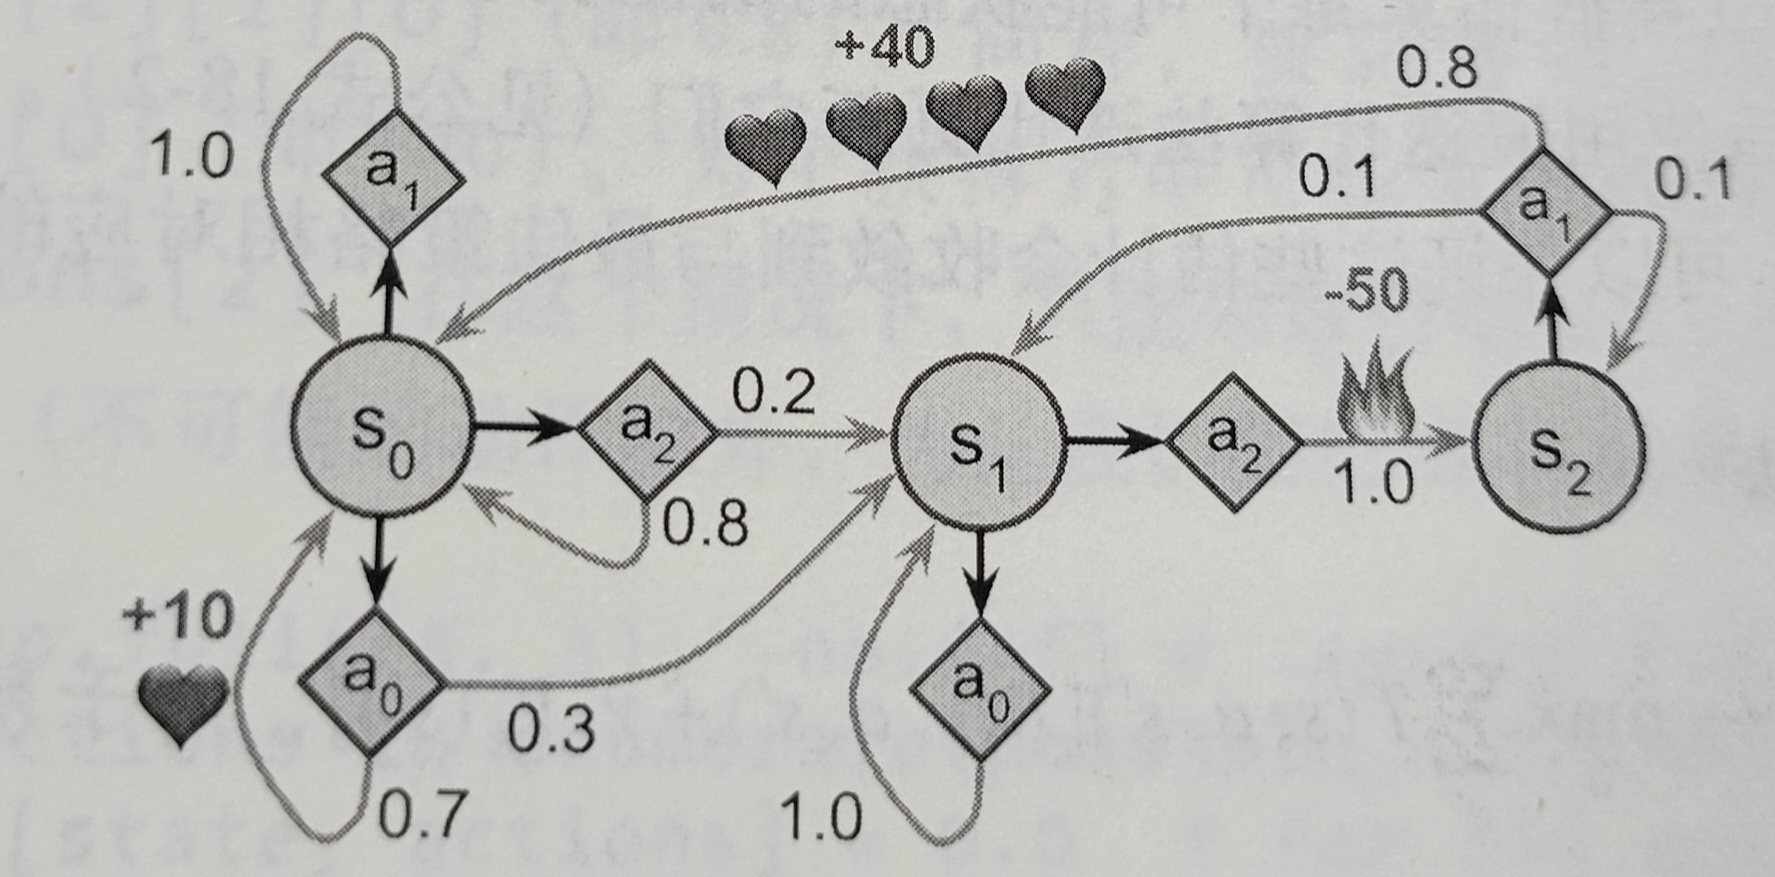

In [3]:
transition_probabilities = [  # shape=[s, a, s']
    [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
    [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
    [None, [0.8, 0.1, 0.1], None]
]
rewards = [  # shape=[s, a, s']
    [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
    [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
    [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]
]
possible_actions = [[0, 1, 2], [0, 2], [1]]

Q值迭代法

由贝尔曼方程得到的Q值迭代算法公式：

$Q_{k+1}\leftarrow \sum_{s'}T(s,a,s')[R(s,a,s')+\gamma*~max_{a'}~[Q_k(s',a')]]$ ，对于所有$(s',a')$

T(s,a,s')是从状态s到s'的概率，R(s,a,s')是转移获得的奖励，$max_{a'}~[Q_k(s',a')]$是本轮和后面的每一轮中可以获得的最大奖励，即假定后面每一步都按照最好的`历史记录`采取动作

In [4]:
Q_values = np.full((3, 3), -np.inf)  # 对所有动作给负无穷
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0  # 对于可能的动作给0

In [5]:
Q_values

array([[  0.,   0.,   0.],
       [  0., -inf,   0.],
       [-inf,   0., -inf]])

In [19]:
gamma = 0.90  # 折扣因子

history1 = []  # 迭代的历史信息
for iteration in range(50):
    Q_prev = Q_values.copy()
    history1.append(Q_prev) # 记录历史信息
    # 应用Q值迭代算法
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                    transition_probabilities[s][a][sp]
                    * (rewards[s][a][sp] + gamma * Q_prev[sp].max())
                for sp in range(3)])

history1 = np.array(history1)  # 整理历史信息

In [5]:
Q_values

array([[18.91891892, 17.02702702, 13.62162162],
       [ 0.        ,        -inf, -4.87971488],
       [       -inf, 50.13365013,        -inf]])

In [6]:
Q_values.argmax(axis=1) # 每一步采取获得最大值的动作的序号

array([0, 0, 1], dtype=int64)

In [7]:
history1 = np.array(history1)

In [8]:
history1

array([[[  0.        ,   0.        ,   0.        ],
        [  0.        ,         -inf,   0.        ],
        [        -inf,   0.        ,         -inf]],

       [[  7.        ,   0.        ,   0.        ],
        [  0.        ,         -inf, -50.        ],
        [        -inf,  32.        ,         -inf]],

       [[ 11.41      ,   6.3       ,   5.04      ],
        [  0.        ,         -inf, -21.2       ],
        [        -inf,  39.92      ,         -inf]],

       [[ 14.1883    ,  10.269     ,   8.2152    ],
        [  0.        ,         -inf, -14.072     ],
        [        -inf,  43.808     ,         -inf]],

       [[ 15.938629  ,  12.76947   ,  10.215576  ],
        [  0.        ,         -inf, -10.5728    ],
        [        -inf,  46.158296  ,         -inf]],

       [[ 17.04133627,  14.3447661 ,  11.47581288],
        [  0.        ,         -inf,  -8.4575336 ],
        [        -inf,  47.63005952,         -inf]],

       [[ 17.73604185,  15.33720264,  12.26976211],


马尔可夫决策过程，即Q值迭代法，需要预先知道动作转移的概率，奖励和可以做的动作，然而现实情况下，动作转移概率很难提前得知

# 时序差分学习

不懂..

# Q学习

在不知道动作转移概率的情况下，让智能体随机选择动作，从而改善对Q值的估计

$Q(s,a)\leftarrow_a~r+\gamma~*max_a Q(s',a')$

$r$是采取动作a获得的奖励的移动平均值，$\gamma~*max_a Q(s',a')$是折扣未来报酬之和

In [107]:
# 步骤函数
def step(state, action):
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0, 1, 2], p=probas)
    reward = rewards[state][action][next_state]
    return next_state, reward

In [108]:
# 随机选择一个动作
def exploration_policy(state):
    return np.random.choice(possible_actions[state])

In [109]:
np.random.seed(42)
# 初始化Q表
Q_values = np.full((3, 3), -np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state][actions] = 0

In [110]:
# 转移概率
transition_probabilities = [  # shape=[s, a, s']
    [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
    [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
    [None, [0.8, 0.1, 0.1], None]
]

In [111]:
alpha0 = 0.05  # 初始学习率
decay = 0.005  # 学习率衰减
gamma = 0.90  # 折扣因子
state = 0  # 初始状态
history2 = []  # 历史Q表
al_history = []

for iteration in range(10_000):
    history2.append(Q_values.copy())  # 增加历史记录
    action = exploration_policy(state) # 随机选择动作
    next_state, reward = step(state, action) # 采取动作，获得下一个状态
    
    next_value = Q_values[next_state].max()  # 贪婪策略，直接选择Q值最高的动作，或者设置一个衰减概率选择其他动作
    alpha = alpha0 / (1 + iteration * decay) # 学习率衰减
    al_history.append(1 - alpha)
    Q_values[state, action] *= 1 - alpha # 原先部分保留(1-alpha)，被修改的部分权重是alpha（衰减）👇
    Q_values[state, action] += alpha * (reward + gamma * next_value)
    state = next_state

history2 = np.array(history2)  # 整理Q表

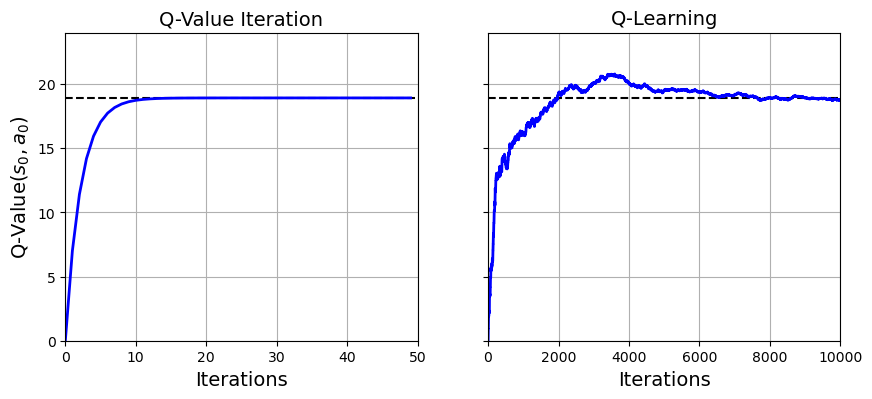

In [112]:
true_Q_value = history1[-1, 0, 0] # 任意选一个Q值作为索引接口，该值在多次迭代后将稳定

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].set_ylabel("Q-Value$(s_0, a_0)$", fontsize=14)
axes[0].set_title("Q-Value Iteration", fontsize=14)
axes[1].set_title("Q-Learning", fontsize=14)
for ax, width, history in zip(axes, (50, 10000), (history1, history2)):
    ax.plot([0, width], [true_Q_value, true_Q_value], "k--")
    ax.plot(np.arange(width), history[:, 0, 0], "b-", linewidth=2) # 对应基准Q值索引
    ax.set_xlabel("Iterations", fontsize=14)
    ax.axis([0, width, 0, 24])
    ax.grid(True)

plt.show()

Q学习经过几千次迭代效果才与Q迭代法类似，不知道转移概率会使找到最佳策略很困难

# 近似Q学习和深度Q学习（DQN）

In [7]:
import tensorflow as tf
import numpy as np

In [2]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on the CPU

input_shape = [4]  # == env.observation_space.shape
n_outputs = 2  # == env.action_space.n

model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    tf.keras.layers.Dense(32, activation="elu"),
    tf.keras.layers.Dense(n_outputs)
])

In [3]:
def epsilon_greedy_policy(state, epsilon=0): # epsilon设定贪婪度，越高则越选择Q值高的动作
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)  # random action
    else:
        Q_values = model.predict(state[np.newaxis], verbose=0)[0]
        return Q_values.argmax()  # optimal action according to the DQN

In [4]:
from collections import deque
# 重播缓存
replay_buffer = deque(maxlen=2000) # 长度2000的双端列表，性质类似list但是处理复杂度更低

In [14]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    # 0~2000的均匀分布，抽取大小为batch_size的随机数组
    batch = [replay_buffer[index] for index in indices] # 按随机序号抽取缓存中的经验
    return [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(6)
    ]  # [states, actions, rewards, next_states, dones, truncateds] 每个元素是一个ndarray数组

In [15]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, truncated, info = env.step(action)
    replay_buffer.append((state, action, reward, next_state, done, truncated)) # 经验缓存中增加经验
    return next_state, reward, done, truncated, info

In [ ]:
# extra code – for reproducibility, and to generate the next figure
env.reset(seed=42)
np.random.seed(42)
tf.random.set_seed(42)
rewards = [] 
best_score = 0

In [ ]:
batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-2) # 优化器
loss_fn = tf.keras.losses.mean_squared_error # 损失函数mse

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences
    next_Q_values = model.predict(next_states, verbose=0) 
    # verbose为0不输出日志，为1有进度条和日志，2为无进度条有日志
    max_next_Q_values = next_Q_values.max(axis=1)
    runs = 1.0 - (dones | truncateds)  # episode is not done or truncated
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs) # 2个动作，2个输出，mask大小为2*2
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))